In [ ]:
import sys
sys.path.append("..")
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # or "0,1" for multiple GPUs

In [1]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
from PIL import Image

/home/nicola/Development/GRINS/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
moondream = AutoModelForCausalLM.from_pretrained(
    "moondream/moondream3-preview",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
    device_map={"": "cuda"},
)
moondream.compile()

Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


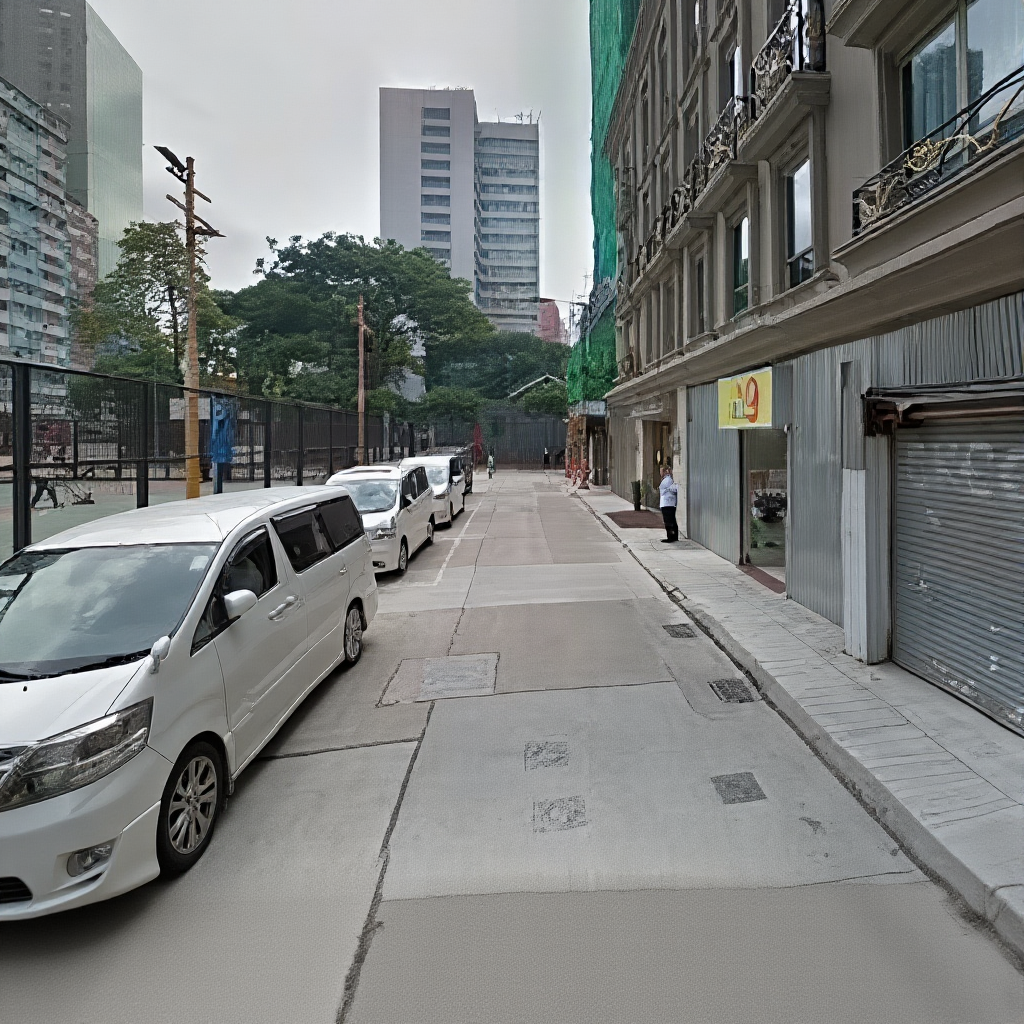

In [3]:
image = Image.open("output.png").convert("RGB")
image

In [4]:
result = moondream.query(image=image, question="Write 5 image editing prompts for improving the perceived safety of this street scene. For each possible improvement, provide a json with the keys 'prompt', 'explanation' and 'localization', where the localization should correspond to a short description of the region and its location in the image.")
# result = moondream.query(image=image, question="Which objects are shown in the image?")
print(result["answer"])

{
    "prompt_1": {
      "prompt": "Add visible security cameras along the street.",
      "explanation": "Enhances safety by deterring potential criminal activity.",
      "localization": "Upper right side of the image, near a fence."
    },
    "prompt_2": {
      "prompt": "Install motion-activated streetlights.",
      "explanation": "Increases visibility at night, improving safety.",
      "localization": "Mid-left side of the image."
    },
    "prompt_3": {
      "prompt": "Paint the curb white.",
      "explanation": "Creates a clear visual boundary and improves visibility.",
      "localization": "Near the center of the image."
    },
    "prompt_4": {
      "prompt": "Trim overgrown vegetation.",
      "explanation": "Restores natural barriers and improves pedestrian access.",
      "localization": "Mid-left side of the image."
    },
    "prompt_5": {
      "prompt": "Install a pedestrian crossing signal.",
      "explanation": "Improves pedestrian safety by providing clear

In [ ]:
result

In [ ]:
result = moondream.detect(image, "Near the intersection on the left side of the street.")

# Bounding boxes are normalized coordinates (0-1)
for i, obj in enumerate(result["objects"]):
    print(f"Object {i+1}: "
          f"x_min={obj['x_min']:.3f}, y_min={obj['y_min']:.3f}, "
          f"x_max={obj['x_max']:.3f}, y_max={obj['y_max']:.3f}")

In [ ]:
# ...existing code...

import torchvision.transforms as T
from torchvision.utils import draw_bounding_boxes
import torch

# Suppose 'output' is your list of dicts with 'bbox_2d' and 'prompt'
# Example: output = [{"bbox_2d": [x1, y1, x2, y2], "prompt": "Add a tree"}, ...]

# Convert PIL image to tensor (C, H, W) and scale to [0, 255]
img_tensor = T.ToTensor()(image) * 255
img_tensor = img_tensor.type(torch.uint8)

# Prepare bounding boxes and labels
boxes = torch.tensor([[obj["x_min"] * image.width, 
                        obj["y_min"] * image.height,
                        obj["x_max"] * image.width,
                        obj["y_max"] * image.height
                      ] for obj in result["objects"]], dtype=torch.int)
labels = [f"Obj {i+1}" for i in range(len(result["objects"]))]

# Draw bounding boxes
img_with_boxes = draw_bounding_boxes(
    img_tensor, boxes, labels=labels, colors="red", width=3, font_size=18
)

# Convert back to PIL for display
from torchvision.transforms.functional import to_pil_image
display(to_pil_image(img_with_boxes))